# Аналитика в Яндекс.Афише

Нам необходимо найти оптимальные действия для оптимизации маркетинговых затрат.Для этого нам необходимо узнать и изучить:

- a) Сколько людей пользуются нашим сервисом в день, неделю, месяц? (DAU,WAU,MAU)
- б) Сколько сессий в среднем день?
- в) Сколько длится в среднем одна сессия?
- г) Как часто люди возвращаются? (Retantion Rate)
- д) Когда люди начинают покупать?
- е) Сколько раз покупают за период?
- ж) Какой средний чек?
- з) Сколько денег приносят? (LTV)
- и) Сколько денег потратили? Всего / на каждый источник / по времени
- к) Сколько стоило привлечение одного покупателя из каждого источника?
- л) На сколько окупились расходы? (ROI)

###### План действий:
- 1) Открыть файлы с данными и провести первычный анализ.Обозначить проблемы в данных (пропуски,дубликаты,аномальные значения и т.д.).Предобработка данных. 
- 2) Исследовательский анализ.
- 3) Общий вывод и принятие решения относительно поставленной задачи.

##### Данные:
Таблица **visits** (лог сервера с информацией о посещениях сайта):
* Uid — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Start Ts — дата и время начала сессии
* End Ts — дата и время окончания сессии
* Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица **orders** (информация о заказах):
* Uid — уникальный id пользователя, который сделал заказ
* Buy Ts — дата и время заказа
* Revenue — выручка Яндекс.Афиши с этого заказа

Таблица **costs** (информация о затратах на маркетинг):
* source_id — идентификатор рекламного источника
* dt — дата
* costs — затраты на этот рекламный источник в этот день

Для начал импортируем все библиотеки необходимые для работы.

In [1]:
import warnings 
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
from matplotlib import rcParams

### 1) Открыть файлы с данными и провести первычный анализ.Обозначить проблемы в данных (пропуски,дубликаты,аномальные значения и т.д.)

In [2]:
visits_log = pd.read_csv('/datasets/visits_log.csv')

In [3]:
visits_log

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


In [4]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
visits_log.describe()

,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


Проведя первичный анализ данных, прошел к выводу что стоит привести названия столбцов к нижнему регистру.
Ткк же необходимо перевести данные столбцов с указанием времени к типу datetime.
Сделаем это для всех трех таблиц

In [6]:
visits_log.columns=['device','end_ts','source_id','start_ts','uid']

In [7]:
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'], format='%Y.%m.%dT%H:%M:%S')
visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'], format='%Y.%m.%dT%H:%M:%S')
visits_log

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


In [8]:
orders_log = pd.read_csv('/datasets/orders_log.csv')
orders_log

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [9]:
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [10]:
orders_log.describe()

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


In [11]:
orders_log.columns = ['buy_ts','revenue','uid']

In [12]:
orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'],format='%Y.%m.%dT%H:%M:%S')

In [13]:
costs = pd.read_csv('/datasets/costs.csv')
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [15]:
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


In [16]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y.%m.%dT%H:%M:%S')

In [17]:
costs.columns = ['source_id','acquisition_date','costs']                                           

In [18]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id           2542 non-null int64
acquisition_date    2542 non-null datetime64[ns]
costs               2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Приведем данные в столбцах с указанием даты в таблице visits_log к типу данных datetime64.

In [19]:
visits_log['year'] = visits_log['start_ts'].astype('datetime64[Y]')
visits_log['day'] = visits_log['start_ts'].astype('datetime64[D]')
visits_log['week'] = visits_log['start_ts'].astype('datetime64[W]')
visits_log['month'] = visits_log['start_ts'].astype('datetime64[M]')

# Исследовательский анализ

Изучим пользовательскую активность.А так же узнаем количество уникальных пользователей по дням, неделям и месяцам (DAU,WAU,MAU), с учетом типа устройства и рекламного источника, по которому пользователь пришел на наш сервис. 

Расчитаем количество пользователей в день по типу устройства (DAU).

In [20]:
dau_device = visits_log.groupby(['device','day']).agg({'uid':'nunique'}).reset_index()

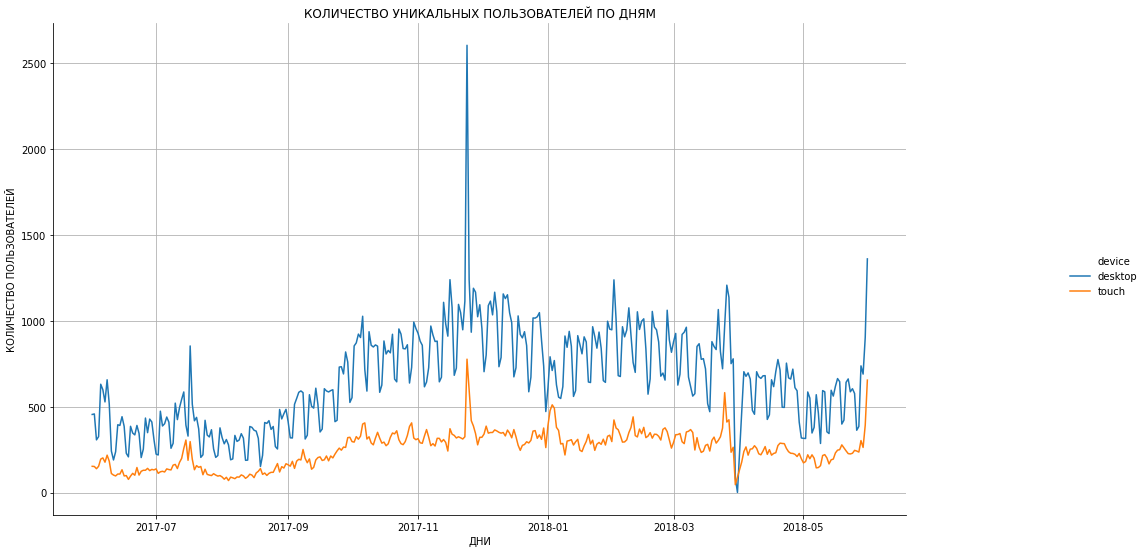

In [21]:
warnings.simplefilter("ignore")
d_dau_device = sns.relplot(x="day", y="uid", hue="device", kind="line", data=dau_device)
plt.grid(True)
d_dau_device.fig.set_figheight(8)
d_dau_device.fig.set_figwidth(18)
plt.xlabel('ДНИ')
plt.ylabel('КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ')
plt.title('КОЛИЧЕСТВО УНИКАЛЬНЫХ ПОЛЬЗОВАТЕЛЕЙ ПО ДНЯМ');

Так же рассчитаем среднее метрики (DAU) по устройствам

In [22]:
dau_device_mean = visits_log.groupby(['device','day']).agg({'uid':'nunique'}).mean()
print()
print('Среднее количество уникальных пользователей в день: {:.0f}'.format(dau_device_mean['uid'].mean()))


Среднее количество уникальных пользователей в день: 456


Расчитаем количество уникальных пользователей в неделю  по типу устройства (WAU)

In [23]:
wau_device = visits_log.groupby(['device','week']).agg({'uid':'nunique'}).reset_index()

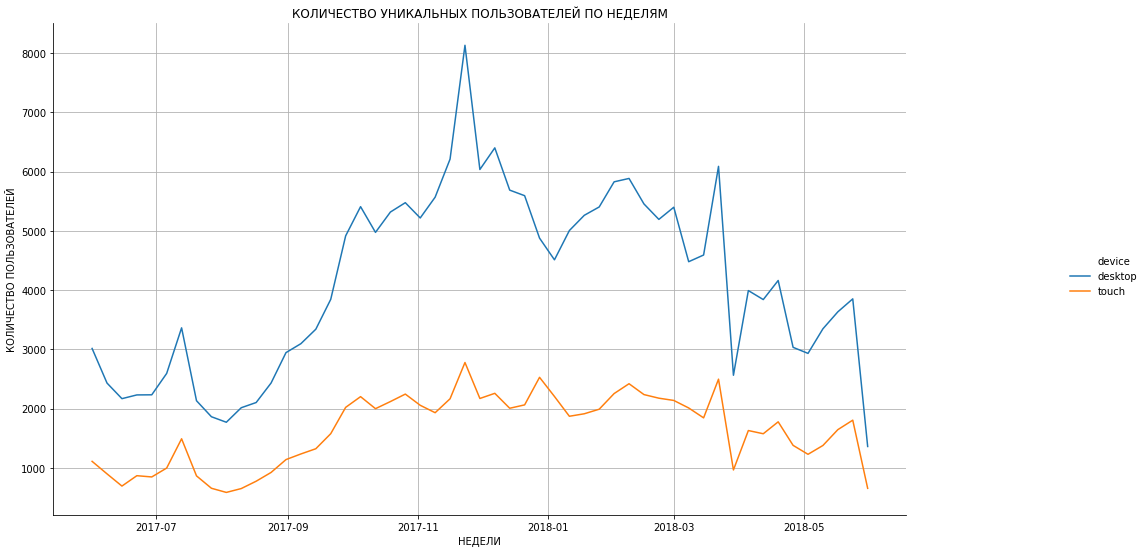

In [24]:
w_wau_device = sns.relplot(x="week", y="uid", hue="device", kind="line", data=wau_device)
plt.grid(True)
w_wau_device.fig.set_figheight(8)
w_wau_device.fig.set_figwidth(18)
plt.xlabel('НЕДЕЛИ')
plt.ylabel('КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ')
plt.title('КОЛИЧЕСТВО УНИКАЛЬНЫХ ПОЛЬЗОВАТЕЛЕЙ ПО НЕДЕЛЯМ');

Так же рассчитаем среднее метрики (WAU) по устройствам

In [25]:
wau_device_maen = visits_log.groupby(['device','week']).agg({'uid':'nunique'}).mean()
print()
print('Среднее количество уникальных пользователей в неделею: {:.0f}'.format(wau_device_maen['uid'].mean()))


Среднее количество уникальных пользователей в неделею: 2887


Расчитаем количество уникальных пользователей в месяц по типу устройства (МAU)

In [26]:
mau_device = visits_log.groupby(['device','month']).agg({'uid':'nunique'}).reset_index()

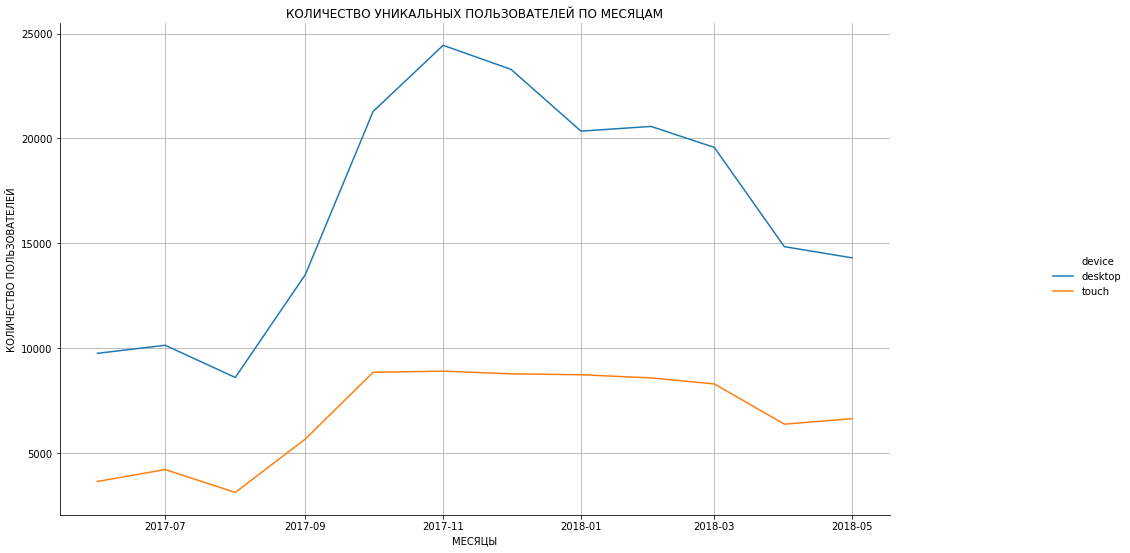

In [27]:
m_mau_device = sns.relplot(x="month", y="uid", hue="device", kind="line", data=mau_device)
plt.grid(True)
m_mau_device.fig.set_figheight(8)
m_mau_device.fig.set_figwidth(18)
plt.xlabel('МЕСЯЦЫ')
plt.ylabel('КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ')
plt.title('КОЛИЧЕСТВО УНИКАЛЬНЫХ ПОЛЬЗОВАТЕЛЕЙ ПО МЕСЯЦАМ');

Так же рассчитаем среднее метрики (MAU) по устройствам

In [28]:
mau_device_mean = visits_log.groupby(['device','month']).agg({'uid':'nunique'}).mean()
print()
print('Среднее количество уникальных пользователей в месяц: {:.0f}'.format(mau_device_mean['uid'].mean()))


Среднее количество уникальных пользователей в месяц: 11775


#### Вывод:
- Если смотреть на метрики показывающие количетсво уникальных пользователей с учетом временого периода(день, неделя, месяц), можно сделать вывод что большая часть пользователей пользуется персональными компьтерами (PC) и ноутбуками, нежели устройствами типа touch.Скорее всего это связанно с тем, что продукт (фильмы,сериалы и т.д.) нашего сервиса лучше подходит для просмотра на PC и ноутбуках.
- Так же можно сказать что чаще пользуются нашим сервисом именно в зименне время года, нежели летом.Скорее всего это связанно с тем что пользователи больше времени проводят в не дома (прогулки, туризм, активный отдых загородом)

Расчитаем количество пользователей в день по идентификатору рекламного источника (DAU)

In [29]:
dau_source = visits_log.pivot_table(index = 'day', columns = 'source_id', values = 'uid', aggfunc = ({'uid': 'nunique'}))

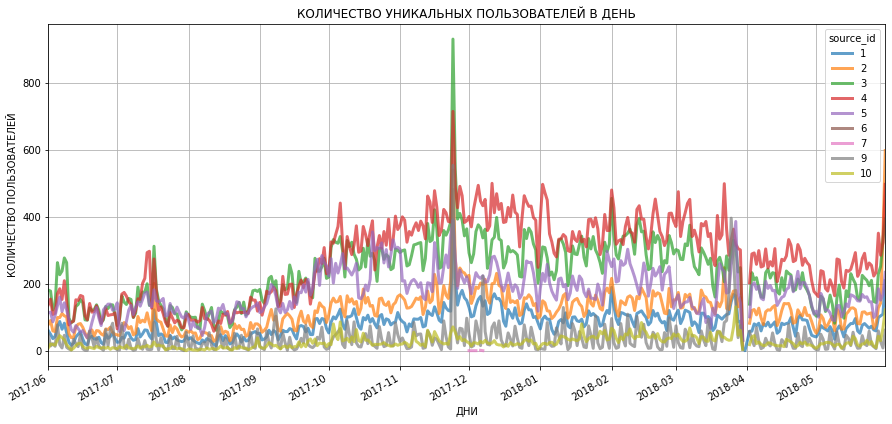

In [30]:
dau_source.plot(linewidth = 3.0, figsize=(15, 7), alpha=0.7)
plt.grid(True)
plt.xlabel('ДНИ')
plt.ylabel('КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ')
plt.title('КОЛИЧЕСТВО УНИКАЛЬНЫХ ПОЛЬЗОВАТЕЛЕЙ В ДЕНЬ');

Так же рассчитаем среднее метрики (DAU) по источникам.

In [31]:
dau_source_mean = dau_source.mean(axis=0).reset_index()
dau_source_mean.columns = ['source_id', 'mean_DAU']
for x,y in zip(dau_source_mean['source_id'],dau_source_mean['mean_DAU']):
    print('Среднее количество уникальных пользователей в день по источнику {} : {}'.format(int(x),int(y)))

Среднее количество уникальных пользователей в день по источнику 1 : 80
Среднее количество уникальных пользователей в день по источнику 2 : 120
Среднее количество уникальных пользователей в день по источнику 3 : 232
Среднее количество уникальных пользователей в день по источнику 4 : 275
Среднее количество уникальных пользователей в день по источнику 5 : 175
Среднее количество уникальных пользователей в день по источнику 6 : 1
Среднее количество уникальных пользователей в день по источнику 7 : 1
Среднее количество уникальных пользователей в день по источнику 9 : 36
Среднее количество уникальных пользователей в день по источнику 10 : 26


In [32]:
dau_source_mean

,source_id,mean_DAU
0,1,80.557692
1,2,120.707989
2,3,232.865014
3,4,275.454545
4,5,175.622590
5,6,1.000000
6,7,1.058824
7,9,36.110193
8,10,26.033058


Расчитаем количество уникальных пользователей в неделю по индефикатору рекламного источника (WAU)

In [33]:
week_source = visits_log.pivot_table(index = 'week', columns = 'source_id', values = 'uid', aggfunc = ({'uid': 'nunique'}))

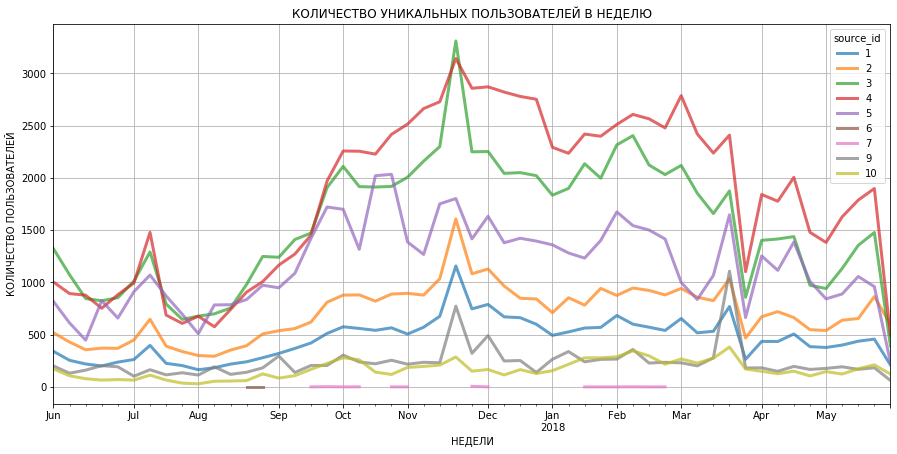

In [34]:
week_source.plot(linewidth = 3.0, figsize=(15, 7), alpha=0.7)
plt.grid(True)
plt.xlabel('НЕДЕЛИ')
plt.ylabel('КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ')
plt.title('КОЛИЧЕСТВО УНИКАЛЬНЫХ ПОЛЬЗОВАТЕЛЕЙ В НЕДЕЛЮ');

In [35]:
week_source_mean = week_source.mean(axis=0).reset_index()
week_source_mean.columns = ['source_id', 'mean_WAU']
for x,y in zip(week_source_mean['source_id'],week_source_mean['mean_WAU']):
    print('Среднее количество уникальных пользователей в неделю по источнику {} : {}'.format(int(x),int(y)))

Среднее количество уникальных пользователей в неделю по источнику 1 : 464
Среднее количество уникальных пользователей в неделю по источнику 2 : 716
Среднее количество уникальных пользователей в неделю по источнику 3 : 1565
Среднее количество уникальных пользователей в неделю по источнику 4 : 1830
Среднее количество уникальных пользователей в неделю по источнику 5 : 1168
Среднее количество уникальных пользователей в неделю по источнику 6 : 1
Среднее количество уникальных пользователей в неделю по источнику 7 : 1
Среднее количество уникальных пользователей в неделю по источнику 9 : 238
Среднее количество уникальных пользователей в неделю по источнику 10 : 166


Расчитаем количество уникальных пользователей в месяц по индефикатору рекламного источника (МAU)

In [36]:
month_source = visits_log.pivot_table(index = 'month', columns = 'source_id', values = 'uid', aggfunc = ({'uid': 'nunique'}))

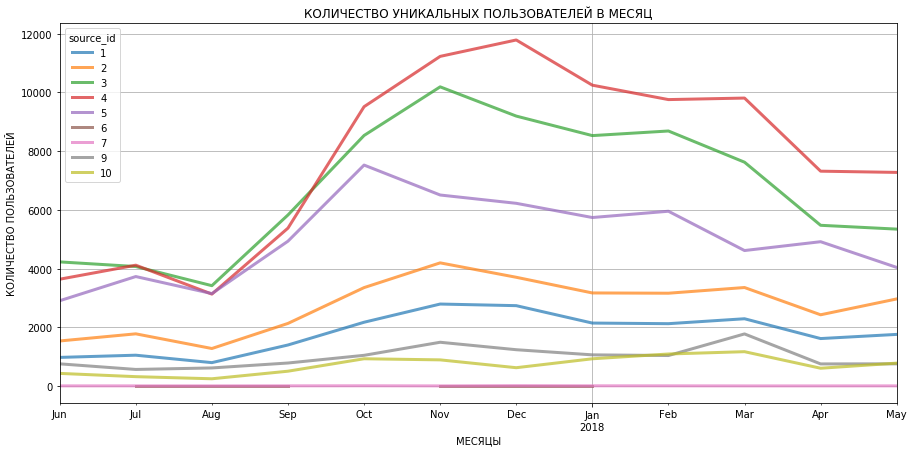

In [37]:
month_source.plot(linewidth = 3.0, figsize=(15, 7), alpha=0.7)
plt.grid(True)
plt.xlabel('МЕСЯЦЫ')
plt.ylabel('КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ')
plt.title('КОЛИЧЕСТВО УНИКАЛЬНЫХ ПОЛЬЗОВАТЕЛЕЙ В МЕСЯЦ');

In [38]:
month_source_mean = month_source.mean(axis=0).reset_index()
month_source_mean.columns = ['source_id', 'mean_MAU']
for x,y in zip(month_source_mean['source_id'],month_source_mean['mean_MAU']):
    print('Среднее количество уникальных пользователей в месяц по источнику {} : {}'.format(int(x),int(y)))

Среднее количество уникальных пользователей в месяц по источнику 1 : 1818
Среднее количество уникальных пользователей в месяц по источнику 2 : 2752
Среднее количество уникальных пользователей в месяц по источнику 3 : 6758
Среднее количество уникальных пользователей в месяц по источнику 4 : 7765
Среднее количество уникальных пользователей в месяц по источнику 5 : 5017
Среднее количество уникальных пользователей в месяц по источнику 6 : 1
Среднее количество уникальных пользователей в месяц по источнику 7 : 2
Среднее количество уникальных пользователей в месяц по источнику 9 : 987
Среднее количество уникальных пользователей в месяц по источнику 10 : 707


#### Вывод:
Если говорить о количестве новых пользователей, относительно рекламного источника, то здесь так же как и в случае с типом устройства выше , можно отметить больший спрос на наш сервис в зимнее (холодное время года). 
Что же касается популярности того или иного типа источника, можно отметить высокую популярность иточников номер 3,4,5.

Рассчитаем среднее количество сессий в день

In [39]:
number_of_sessions_per_day = visits_log.groupby('day').agg({'uid':['count','nunique']})

In [40]:
number_of_sessions_per_day.columns = ['n_sessions', 'n_users']
number_of_sessions_per_day

,n_sessions,n_users
day,,
2017-06-01,664,605
2017-06-02,658,608
2017-06-03,477,445
2017-06-04,510,476
2017-06-05,893,820
...,...,...
2018-05-27,672,620
2018-05-28,1156,1039
2018-05-29,1035,948


In [41]:
number_of_sessions_per_day['sessions_per_user'] = number_of_sessions_per_day['n_sessions'] / number_of_sessions_per_day['n_users']

In [42]:
number_of_sessions_per_day['sessions_per_user'].mean()

1.082169644003972

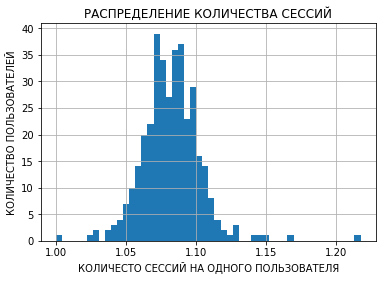

In [43]:
number_of_sessions_per_day['sessions_per_user'].hist(bins=50)
plt.xlabel('КОЛИЧЕСТО СЕССИЙ НА ОДНОГО ПОЛЬЗОВАТЕЛЯ')
plt.ylabel('КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ')
plt.title('РАСПРЕДЕЛЕНИЕ КОЛИЧЕСТВА СЕССИЙ');

#### Вывод:
Как мы видим большая часть пользователей делает 1 сессию в среднем в день,что говорит о небольшой популярности нашего сервиса.

Рассчитаем среднюю продолжительность сессии.

In [44]:
visits_log['session_duration_sec'] = (visits_log['end_ts'] - visits_log['start_ts']).dt.total_seconds()

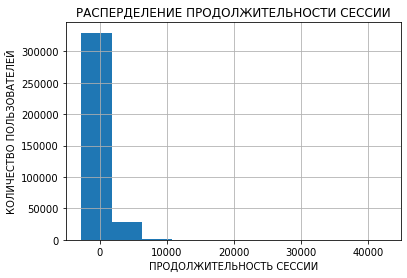

In [45]:
visits_log['session_duration_sec'].hist()
plt.xlabel('ПРОДОЛЖИТЕЛЬНОСТЬ СЕССИИ')
plt.ylabel('КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ')
plt.title('РАСПЕРДЕЛЕНИЕ ПРОДОЛЖИТЕЛЬНОСТИ СЕССИИ');

In [46]:
visits_log['session_duration_sec'].describe()

count    359400.000000
mean        643.025687
std         997.127761
min       -2760.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: session_duration_sec, dtype: float64

Как мы видим по гистограмме есть некоторое количетсво отрицательных значений.Посмотрим сколько их.

In [47]:
visits_log[visits_log['session_duration_sec'] < 0] 

,device,end_ts,source_id,start_ts,uid,year,day,week,month,session_duration_sec
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-01-01,2018-03-25,2018-03-22,2018-03-01,-1920.0
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-01-01,2018-03-25,2018-03-22,2018-03-01,-2760.0


Отрицательных значений продолжительности сессий всего два.Предлагаю удалить эти два значения из наших данных, и обратится к отделу ответственному за выгрузку данных, чтобы обратить внимание на некорректную выгрузку данных.

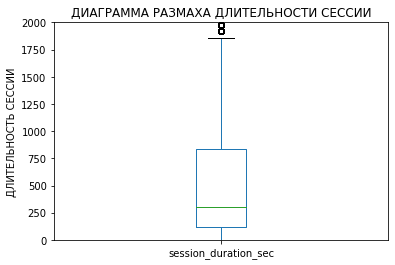

In [48]:
visits_log['session_duration_sec'].plot.box()
plt.ylim(0,2000)
plt.ylabel('ДЛИТЕЛЬНОСТЬ СЕССИИ')
plt.title('ДИАГРАММА РАЗМАХА ДЛИТЕЛЬНОСТИ СЕССИИ');

In [49]:
visits_log_normal_duration = visits_log.query('session_duration_sec > 0 and session_duration_sec < 1850') 

In [50]:
warnings.simplefilter("ignore")
visits_log_normal_duration['session_duration_sec'] = (visits_log_normal_duration['end_ts'] 
                                                      - visits_log_normal_duration['start_ts']).dt.total_seconds()

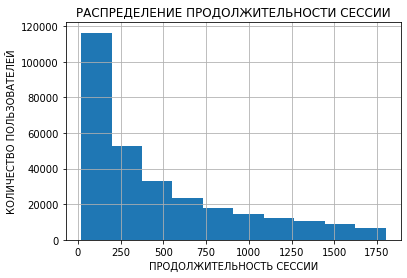

In [51]:
visits_log_normal_duration['session_duration_sec'].hist()
plt.xlabel('ПРОДОЛЖИТЕЛЬНОСТЬ СЕССИИ')
plt.ylabel('КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ')
plt.title('РАСПРЕДЕЛЕНИЕ ПРОДОЛЖИТЕЛЬНОСТИ СЕССИИ');

In [52]:
visits_log_normal_duration['session_duration_sec'].describe()

count    295713.000000
mean        483.363437
std         457.345150
min          19.000000
25%         120.000000
50%         300.000000
75%         720.000000
max        1800.000000
Name: session_duration_sec, dtype: float64

In [53]:
visits_log_normal_duration['session_duration_sec'].median()

300.0

In [54]:
visits_log_normal_duration['session_duration_sec'].mode()

0    60.0
dtype: float64

#### Вывод:
Как мы видим средняя продолжительность сессии состовляет примерно 8 минут.Если смотреть на такой показатель как медиана то половина наших пользователей обращаются к нашему сервису примерно в районе 6 минут за раз.Так же если посмотреть на наши данные, можно сказать что 75% (3/4) наших пользователей проводят в нашем сервисе до 12 минут. Опираясь на эти показатели могу сказать что этого не достаточно, и этот показатель можно и нужно увеличить, например поменять интерфейс, добавить большие интересной информации (познавательной) и нашем продукте

Рассчитаем метрику показывающую,как часто люди возвращаются (Ratention Rate)

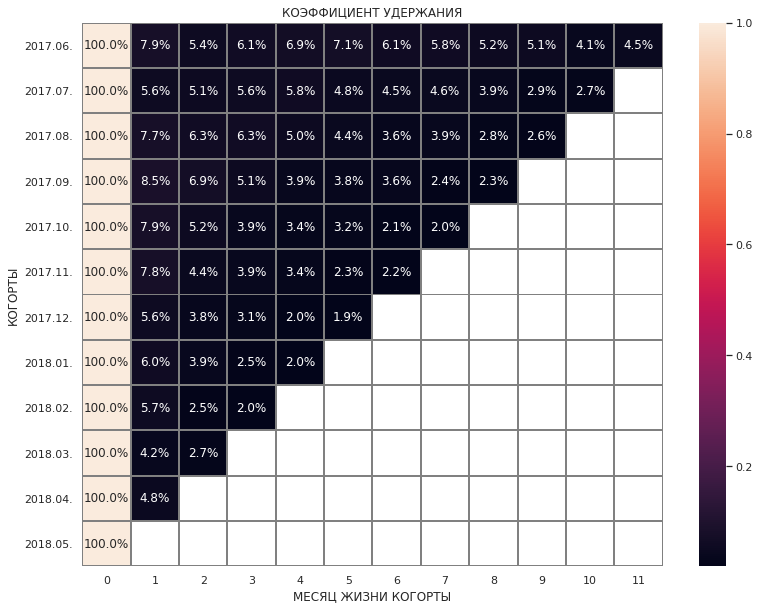

In [55]:
visits_log_retention = visits_log.copy()


# Определим дату первой активности пользователя на сайте и объеденим с исходными данными.
first_activity_date = visits_log_retention.groupby('uid')['start_ts'].min() 
first_activity_date.name = 'first_activity_date'
visits_log_retention = visits_log_retention.join(first_activity_date,on='uid')


# Построим когорты периодом в один месяц (lifetime)
visits_log_retention['first_activity_date'] = visits_log_retention['first_activity_date'].astype('datetime64[M]')

visits_log_retention['start_ts'] = visits_log_retention['start_ts'].astype('datetime64[M]')

visits_log_retention['cohort_lifetime'] = visits_log_retention['start_ts'] - visits_log_retention['first_activity_date']

visits_log_retention['cohort_lifetime'] = visits_log_retention['cohort_lifetime'] / np.timedelta64(1,'M')

visits_log_retention['cohort_lifetime'] = visits_log_retention['cohort_lifetime'].round().astype(int)

cohorts = visits_log_retention.groupby(['first_activity_date','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

# Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю.
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_date','uid']]

initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})


# добавим к таблице с когортами.
cohorts = cohorts.merge(initial_users_count,on='first_activity_date')


cohorts['first_activity_date'] = cohorts['first_activity_date'].dt.strftime('%Y.%m.')

# определим коэфициент удержиния
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

# построим сводную таблицу и вывдем ее на графике heatmap.
retention_pivot = cohorts.pivot_table(index='first_activity_date',columns='cohort_lifetime',values='retention',aggfunc='sum')

sns.set(style='whitegrid')
plt.figure(figsize=(13, 10))
plt.title('КОЭФФИЦИЕНТ УДЕРЖАНИЯ')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.xlabel('МЕСЯЦ ЖИЗНИ КОГОРТЫ')
plt.ylabel('КОГОРТЫ');

#### Вывод:
Как мы видим коэффициент удержания относительно нашего сервиса не высок. Пользователи реже возвращаются к нам.Нужно провести мониторинг, и попытать понять чего ждет пользователь от нашего сервиса, что засталяет его к нам возвращаться.
Что касательно когорт то у всех коэффициент удержания ниже на второй месяц использования сервиса, по отношению к первому месяцу.В дальнейшем коэффициент растет, но опять же недолго.Например у первой когорты он растет следующие три месяца, у второй следующие два месяца.Чем ближе когорта основанна ближе к летнему периоду, тем ниже ее коэффициент удержания в следующие месяцы ее жизни.

Рассчитаем метрику показывающую,как часто люди возвращаются (Ratention Rate) разделяя по типу устройств.

# Desktop

In [56]:
visits_log_d = visits_log.copy()

In [57]:
visits_log_desktop = visits_log_d.query('device =="desktop"')

In [58]:
first_activity_date_desktop = visits_log_desktop.groupby('uid')['start_ts'].min() 

In [59]:
first_activity_date_desktop.name = 'first_activity_date_desktop'

In [60]:
visits_log_desktop = visits_log_desktop.join(first_activity_date_desktop,on='uid')

In [61]:
visits_log_desktop['first_activity_date_desktop'] = visits_log_desktop['first_activity_date_desktop'].astype('datetime64[M]')

In [62]:
visits_log_desktop['start_ts'] = visits_log_desktop['start_ts'].astype('datetime64[M]') 

In [63]:
visits_log_desktop['cohort_lifetime'] = visits_log_desktop['start_ts'] - visits_log_desktop['first_activity_date_desktop']

In [64]:
visits_log_desktop['cohort_lifetime'] = visits_log_desktop['cohort_lifetime'] / np.timedelta64(1,'M')

In [65]:
visits_log_desktop['cohort_lifetime'] = visits_log_desktop['cohort_lifetime'].round().astype(int)

In [66]:
cohorts = visits_log_desktop.groupby(['first_activity_date_desktop','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [67]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_date_desktop','uid']]

In [68]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [69]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_date_desktop')

In [70]:
cohorts['first_activity_date_desktop'] = cohorts['first_activity_date_desktop'].dt.strftime('%Y.%m.')

In [71]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [72]:
retention_pivot_desktop = cohorts.pivot_table(index='first_activity_date_desktop',columns='cohort_lifetime',values='retention',aggfunc='sum')

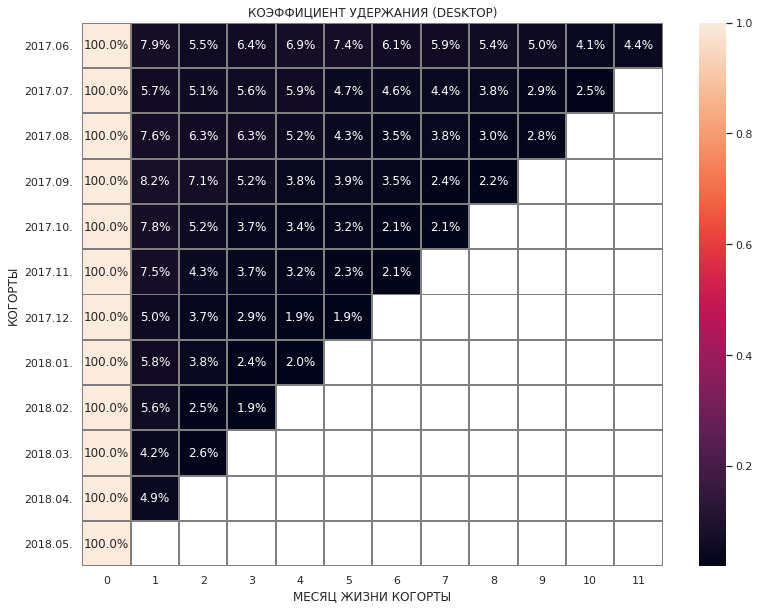

In [73]:
sns.set(style='whitegrid')
plt.figure(figsize=(13, 10))
plt.title('КОЭФФИЦИЕНТ УДЕРЖАНИЯ (DESKTOP)')
sns.heatmap(retention_pivot_desktop, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.xlabel('МЕСЯЦ ЖИЗНИ КОГОРТЫ')
plt.ylabel('КОГОРТЫ');

# Touch

In [74]:
visits_log_t = visits_log.copy()

In [75]:
visits_log_touch= visits_log_t.query('device =="touch"')

In [76]:
first_activity_date_touch= visits_log_touch.groupby('uid')['start_ts'].min() 

In [77]:
first_activity_date_touch.name = 'first_activity_date_touch'

In [78]:
visits_log_touch = visits_log_touch.join(first_activity_date_touch,on='uid')

In [79]:
visits_log_touch['first_activity_date_touch'] = visits_log_touch['first_activity_date_touch'].astype('datetime64[M]')

In [80]:
visits_log_touch['start_ts'] = visits_log_touch['start_ts'].astype('datetime64[M]') 

In [81]:
visits_log_touch['cohort_lifetime'] = visits_log_touch['start_ts'] - visits_log_touch['first_activity_date_touch']

In [82]:
visits_log_touch['cohort_lifetime'] = visits_log_touch['cohort_lifetime'] / np.timedelta64(1,'M')

In [83]:
visits_log_touch['cohort_lifetime'] = visits_log_touch['cohort_lifetime'].round().astype(int)

In [84]:
cohorts = visits_log_touch.groupby(['first_activity_date_touch','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [85]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_date_touch','uid']]

In [86]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [87]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_date_touch')

In [88]:
cohorts['first_activity_date_touch'] = cohorts['first_activity_date_touch'].dt.strftime('%Y.%m.')

In [89]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [90]:
retention_pivot_touch = cohorts.pivot_table(index='first_activity_date_touch',columns='cohort_lifetime',values='retention',aggfunc='sum')

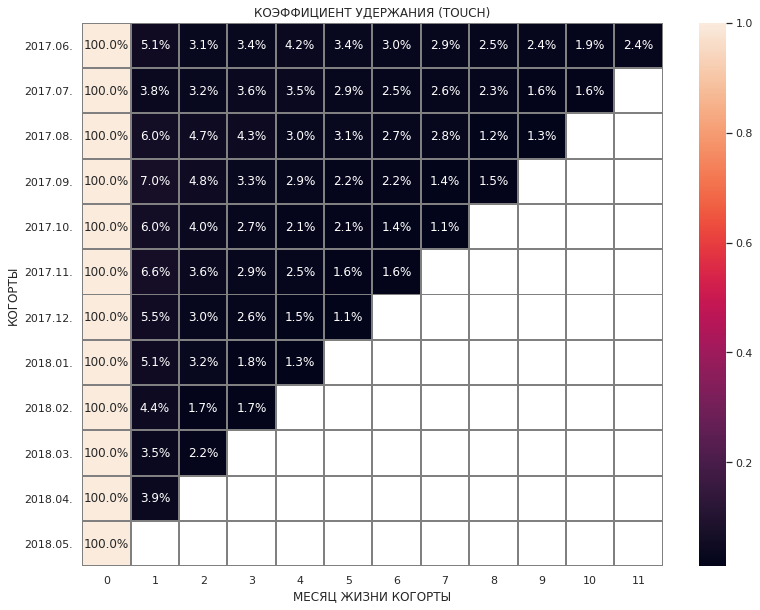

In [91]:
sns.set(style='whitegrid')
plt.figure(figsize=(13, 10))
plt.title('КОЭФФИЦИЕНТ УДЕРЖАНИЯ (TOUCH)')
sns.heatmap(retention_pivot_touch, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.xlabel('МЕСЯЦ ЖИЗНИ КОГОРТЫ')
plt.ylabel('КОГОРТЫ');

#### Вывод:
Также посчитав коэфициент удержания с разбивкой на утройства,можно отметить небольшие отличия, в пользу PC.Коэфициент удержания пользователей по типу устройства PC несколько выше, нежели по типу устройства touch.Это подтверждает нашу теорию, высказанную выше: пользователи больше используют тип устройства PC при пользовании услуг нашего сервиса.Стоит задуматься над версией нашего сайта для touch.Скорее всего там нужны доработки. 

Рассчитаем среднее время первой покупки.
За отсчет времени возьмем время первой активности.

In [92]:
first_starts_ts = visits_log.groupby('uid')['start_ts'].min()

first_buy_ts = orders_log.groupby('uid')['buy_ts'].min()

first_purchase = first_starts_ts.to_frame().join(first_buy_ts.to_frame(),on ='uid', how = 'inner')

In [93]:
first_purchase

,start_ts,buy_ts
uid,,
313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
...,...,...
18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00
18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00
18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00


In [94]:
first_purchase['first_purchase'] = first_purchase['buy_ts'] - first_purchase['start_ts']
first_purchase['first_purchase'].describe()

count                      36523
mean     16 days 21:40:10.550064
std      47 days 01:44:46.481416
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:16:00
75%              2 days 00:17:00
max            363 days 07:04:00
Name: first_purchase, dtype: object

In [95]:
first_purchase['first_purchase'].mode()

0   00:01:00
dtype: timedelta64[ns]

#### Вывод:
Как мы видим среднее время первой покупки составляет две недели.Хотя меньше 75% соверщают покупку в первые два дня.Скорее всего есть пользователи, которые очень долго не совершают покупки в нашем сервисе.Предлагаю рассмотреть предложения для наших пользователей касательно цен для наших первых покупателей, может быть стоит ввести какую-то систему поощрений за первыую покупку,скидки.

Рассчитаем сколько покупают за периоды (день,неделя,месяц)

In [96]:
orders_log_purchases = orders_log.copy()

In [97]:
orders_log_purchases['buy_ts_date'] = orders_log_purchases['buy_ts'].astype('datetime64[D]')
orders_log_purchases['buy_ts_week'] = orders_log_purchases['buy_ts'].astype('datetime64[W]')
orders_log_purchases['buy_ts_month'] = orders_log_purchases['buy_ts'].astype('datetime64[M]')

In [98]:
orders_log_purchases_day = orders_log_purchases.groupby('buy_ts_date').agg({'uid':'count'})
orders_log_purchases_day = orders_log_purchases_day.reset_index()
orders_log_purchases_day.describe()

,uid
count,364.000000
mean,138.502747
std,76.858480
min,1.000000
25%,82.750000
50%,136.000000
75%,177.000000
max,814.000000


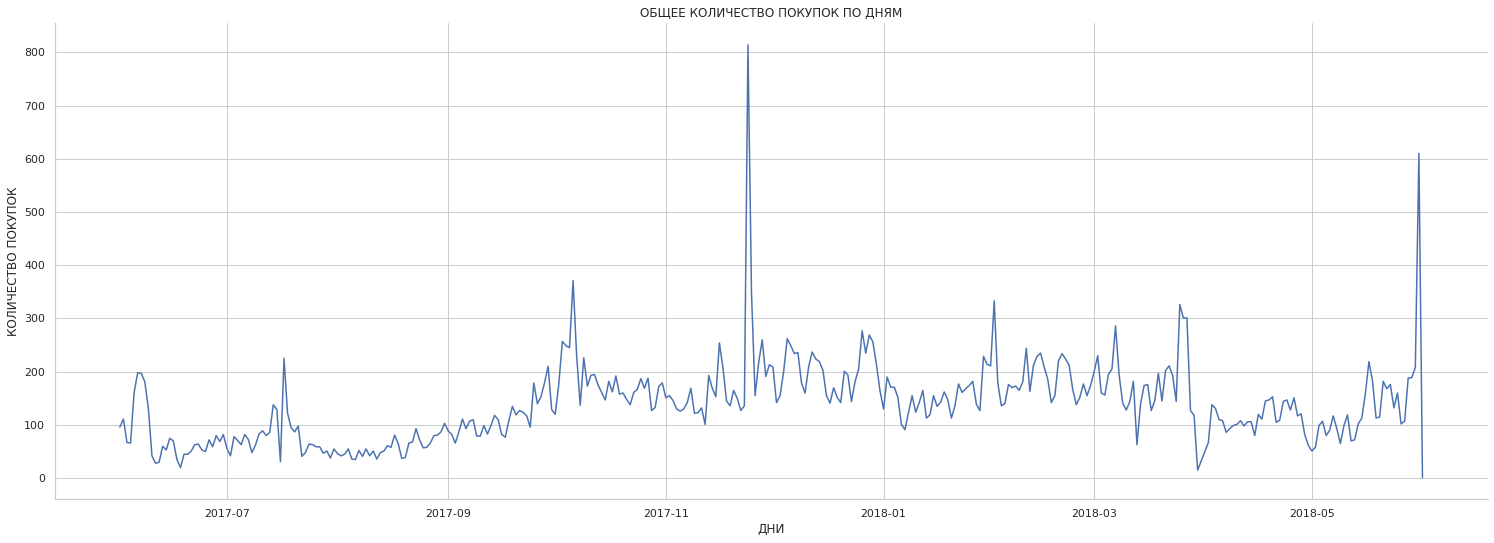

In [99]:
orders_log_purchases_day_d = sns.relplot(x="buy_ts_date", y="uid", kind="line", data=orders_log_purchases_day)
orders_log_purchases_day_d.fig.set_figheight(8)
orders_log_purchases_day_d.fig.set_figwidth(25)
plt.xlabel('ДНИ')
plt.ylabel('КОЛИЧЕСТВО ПОКУПОК')
plt.title('ОБЩЕЕ КОЛИЧЕСТВО ПОКУПОК ПО ДНЯМ');

In [100]:
orders_log_purchases_week = orders_log_purchases.groupby('buy_ts_week').agg({'uid':'count'})
orders_log_purchases_week = orders_log_purchases_week.reset_index()
orders_log_purchases_week.describe()

,uid
count,53.000000
mean,951.226415
std,405.229880
min,319.000000
25%,631.000000
50%,972.000000
75%,1214.000000
max,2120.000000


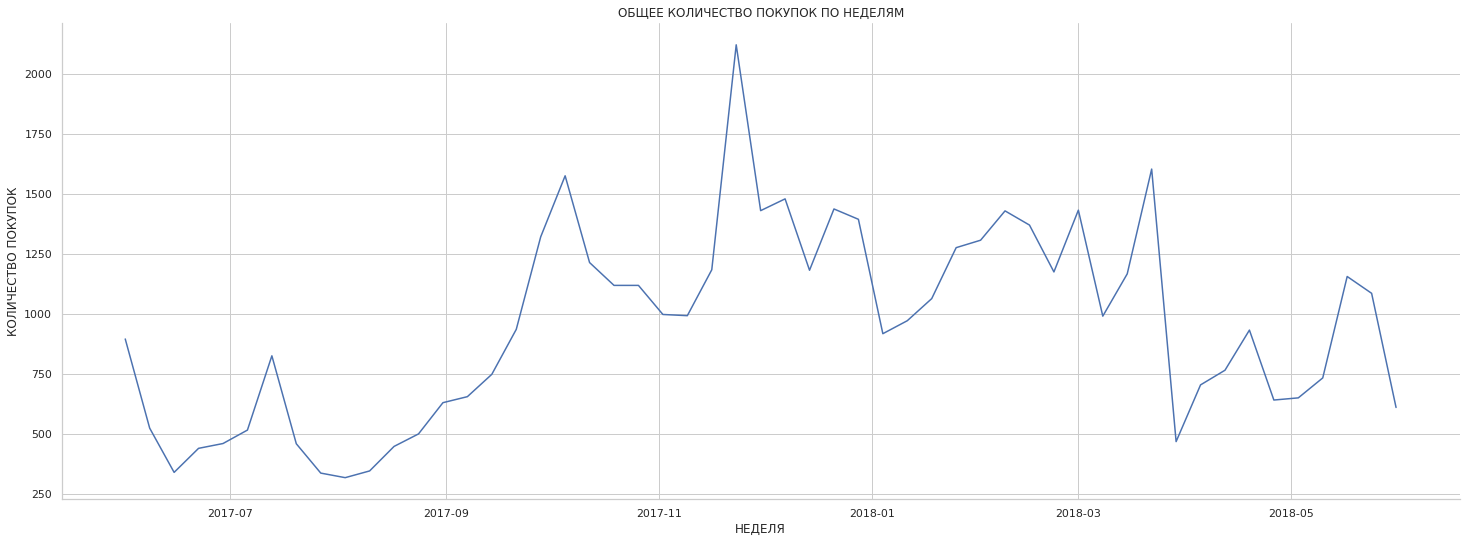

In [101]:
orders_log_purchases_week_w = sns.relplot(x="buy_ts_week", y="uid", kind="line", data=orders_log_purchases_week)
orders_log_purchases_week_w.fig.set_figheight(8)
orders_log_purchases_week_w.fig.set_figwidth(25)
plt.xlabel('НЕДЕЛЯ')
plt.ylabel('КОЛИЧЕСТВО ПОКУПОК')
plt.title('ОБЩЕЕ КОЛИЧЕСТВО ПОКУПОК ПО НЕДЕЛЯМ');

In [102]:
orders_log_purchases_month = orders_log_purchases.groupby('buy_ts_month').agg({'uid':'count'})
orders_log_purchases_month = orders_log_purchases_month.reset_index()
orders_log_purchases_month.describe()

,uid
count,13.000000
mean,3878.076923
std,1858.113401
min,1.000000
25%,2363.000000
50%,4346.000000
75%,5326.000000
max,6218.000000


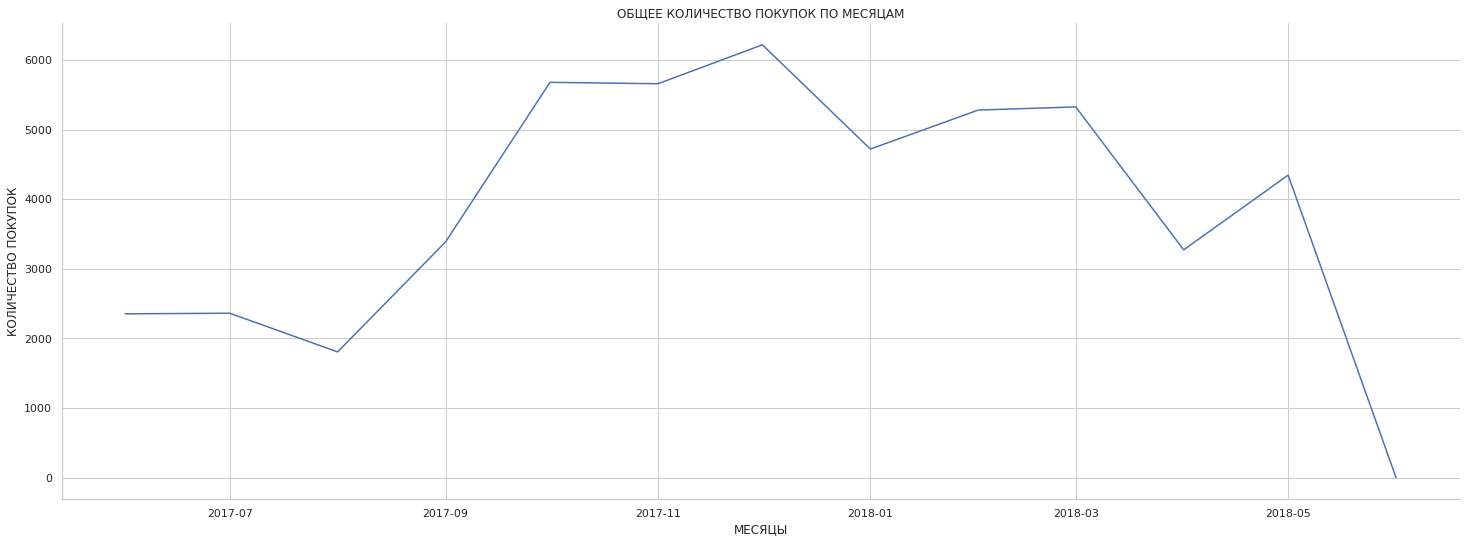

In [103]:
orders_log_purchases_month_m = sns.relplot(x="buy_ts_month", y="uid", kind="line", data=orders_log_purchases_month)
orders_log_purchases_month_m.fig.set_figheight(8)
orders_log_purchases_month_m.fig.set_figwidth(25)
plt.xlabel('МЕСЯЦЫ')
plt.ylabel('КОЛИЧЕСТВО ПОКУПОК')
plt.title('ОБЩЕЕ КОЛИЧЕСТВО ПОКУПОК ПО МЕСЯЦАМ');

#### Вывод:
Как мы видим из выше перечисленных графиков, чаще всего покупки совершают в период с сентября по март.И обратно-пропорционая картина обстоит с покупками в летний период.Думаю стоит разработать дополнительную систему скидок в летний период. 

Рассчитаем как изменяется средний чек в зависимости от времени, прошедшего с момента первой покупки

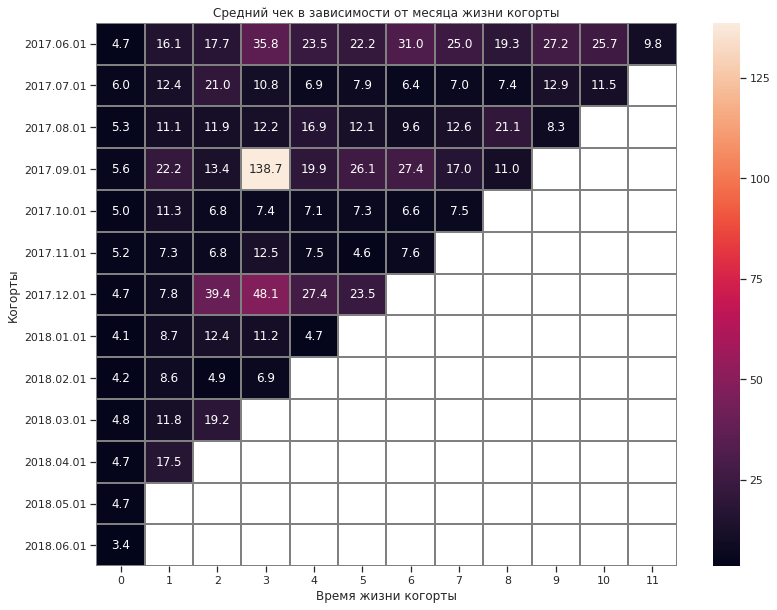

In [104]:
orders_log_new = orders_log.copy()

first_buy_ts_date_by_customers= orders_log_new.groupby('uid')['buy_ts'].min() 

first_buy_ts_date_by_customers.name = 'first_buy_ts_date'

orders_log_new = orders_log_new.join(first_buy_ts_date_by_customers, on='uid')

orders_log_new['first_buy_ts_month'] = orders_log_new['first_buy_ts_date'].astype('datetime64[M]')

orders_log_new['buy_ts_month'] = orders_log_new['buy_ts'].astype('datetime64[M]')

orders_log_new_grouped_by_cohorts = (orders_log_new.groupby(['first_buy_ts_month','buy_ts_month'])
                                     .agg({'revenue':'sum','uid':'nunique'}))

orders_log_new_grouped_by_cohorts['revenue_per_user'] = (orders_log_new_grouped_by_cohorts['revenue']
                                                         / orders_log_new_grouped_by_cohorts['uid'])

average_check_pivot_table = orders_log_new_grouped_by_cohorts.pivot_table(index='first_buy_ts_month', columns ='buy_ts_month', 
                                                                          values ='revenue_per_user', aggfunc = 'mean')


orders_log_new_grouped_by_cohorts = orders_log_new_grouped_by_cohorts.reset_index()

orders_log_new_grouped_by_cohorts['cohort_lifetime'] = (orders_log_new_grouped_by_cohorts['buy_ts_month'] - 
                                                        orders_log_new_grouped_by_cohorts['first_buy_ts_month'])

orders_log_new_grouped_by_cohorts['cohort_lifetime'] = (orders_log_new_grouped_by_cohorts['cohort_lifetime']
                                                        / np.timedelta64(1, 'M'))

orders_log_new_grouped_by_cohorts['cohort_lifetime'] = orders_log_new_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

orders_log_new_grouped_by_cohorts['first_buy_ts_month'] = orders_log_new_grouped_by_cohorts['first_buy_ts_month'].dt.strftime('%Y.%m.%d')

orders_log_new_grouped_by_cohorts_by_time = orders_log_new_grouped_by_cohorts.pivot_table(index='first_buy_ts_month',columns='cohort_lifetime',
                                                                                          values='revenue_per_user',aggfunc='mean')

sns.set(style='ticks')
plt.figure(figsize=(13, 10))
plt.title('Средний чек в зависимости от месяца жизни когорты')
sns.heatmap(orders_log_new_grouped_by_cohorts_by_time, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.ylabel('Когорты')
plt.xlabel('Время жизни когорты');

#### Вывод:
Самый большой средний чек можно наблюдать у 1 когорты, когорты номер 4 и когорты номер 7. Средний чек в этих когортах растет первые 4-5 месяцев после начала использования нашего сервиса. В дальнейшем средний чек в когортах падает.Думаю первое времея нашим пользователям интересно использование нашего сервиса.В дальнейшем интерес падает.Необходимо выяснить с чем это связано.Может стоит провести опрос пользователей, которые полузуются нашим сервисов больше 4-5 месяцев.

Создадим профиль пользователя.В дальнейшем это нам поможет при вычислении LTV и ROI.

In [105]:
visits = visits_log.copy()
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

orders = orders_log.copy()
orders['buy_ts'] = pd.to_datetime(visits['end_ts'])
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['week'] =  orders['buy_ts'].dt.week



#Постороим профили пользователей
users = (visits.sort_values(by = ['uid','start_ts'])
        .groupby('uid')
        .agg({'start_ts' : 'first', 'source_id' : 'first', 'device' : 'first'})
        .rename(columns = {'start_ts' : 'acquisition_ts'}))
users['acquisition_date'] = users['acquisition_ts'].dt.date
users['acquisition_month'] = users['acquisition_ts'].astype('datetime64[M]')
users = (users.reset_index()
        .set_index(['source_id','acquisition_date'])
        .join(costs.set_index(['source_id','acquisition_date']), how = 'left'))




#Добавим стоимость приобретения индивидуального пользователя
user_cost = (users.groupby(['source_id','acquisition_date'])
            .agg({'device':'count', 'costs':'max'})
            .rename(columns = {'device':'users'}))
user_cost['acqusition_cost'] = user_cost['costs'] / user_cost['users']
users = users.join(user_cost[['acqusition_cost']], how = 'left')
users = users.reset_index().set_index('uid')[['acquisition_ts','acquisition_date','acquisition_month',
                                              'source_id','device','acqusition_cost']]



#Построим профили пользователей
paying_users = (visits[visits['uid'].isin(orders['uid'].unique())]
          .sort_values(by = ['uid','start_ts']).groupby('uid')
          .agg({'start_ts':'first','source_id':'first','device':'first'})
          .rename(columns = {'start_ts':'acquisition_ts'}))
paying_users['acquisition_date'] = paying_users['acquisition_ts'].dt.date
paying_users['acquisition_month'] = paying_users['acquisition_ts'].astype('datetime64[M]')
paying_users =(paying_users.reset_index().set_index(['source_id','acquisition_date'])
              .join(costs.set_index(['source_id','acquisition_date']), how = 'left'))

#Добавим стоимость приобретения индивидуального пользователя
user_cost = (paying_users.groupby(['source_id','acquisition_date'])
            .agg({'device':'count','costs':'max'})
            .rename(columns = {'device':'users'}))
user_cost['payer_acqusition_cost'] = user_cost['costs']/user_cost['users']
paying_users = paying_users.join(user_cost[['payer_acqusition_cost']],how='left')
paying_users = paying_users.reset_index().set_index('uid')[['acquisition_ts','acquisition_date','acquisition_month',
                                              'source_id','device','payer_acqusition_cost']]

paying_users = (paying_users.join(orders.groupby('uid')
                                 .agg({'revenue':'sum'})
                                 .rename(columns = {'revenue' : 'total_revenue'}), how ='left'))


#Объединяем пользователей, которые платят и тех которые неплатят
users = users.join(paying_users[['payer_acqusition_cost','total_revenue']], how = 'left')
users['payer'] = ~users['payer_acqusition_cost'].isna()

users

,acquisition_ts,acquisition_date,acquisition_month,source_id,device,acqusition_cost,payer_acqusition_cost,total_revenue,payer
uid,,,,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.600000,3.133333,70.69,True
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.600000,NaN,NaN,False
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.600000,3.133333,0.37,True
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.600000,3.133333,4.28,True
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.600000,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...
17550479715346067160,2018-05-31 22:00:00,2018-05-31,2018-05-01,10,touch,0.177778,NaN,NaN,False
17715613363403416471,2018-05-31 03:30:00,2018-05-31,2018-05-01,10,desktop,0.177778,NaN,NaN,False
18076428844159112818,2018-05-31 17:47:00,2018-05-31,2018-05-01,10,touch,0.177778,NaN,NaN,False


Попытаемся определить сколько было потраченно на привлечение пользователей по месяцам

In [106]:
users_costs_total_by_source_id= users.pivot_table(index = 'acquisition_month', columns = 'source_id', values ='acqusition_cost', aggfunc = ({'acqusition_cost':'sum'}))
users_costs_total_by_source_id

source_id,1,2,3,4,5,6,7,9,10
acquisition_month,,,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,NaN,0.0,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,0.0,0.0,292.76,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,NaN,0.0,248.93,231.20
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,NaN,0.0,407.07,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,NaN,0.0,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,0.0,0.0,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,NaN,0.0,648.66,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,NaN,0.0,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,NaN,0.0,536.18,480.88


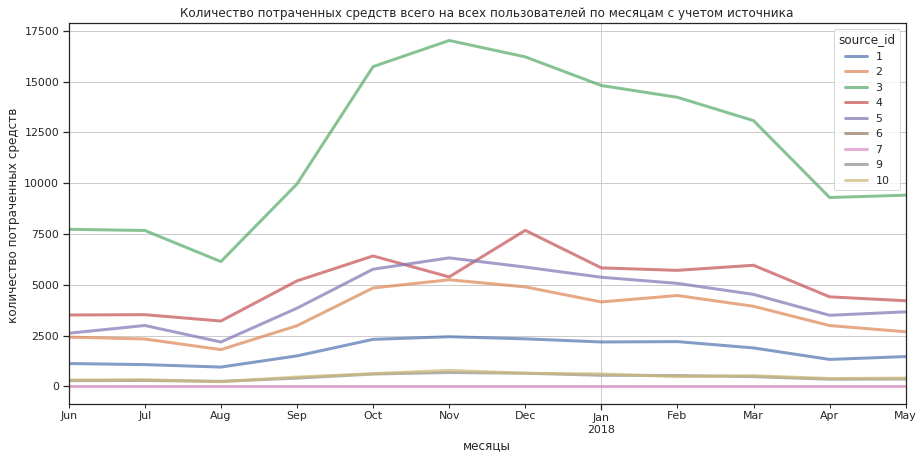

In [107]:
users_costs_total_by_source_id.plot(linewidth = 3.0, figsize=(15, 7), alpha=0.7)
plt.grid(True)
plt.xlabel('месяцы')
plt.ylabel('количество потраченных средств ')
plt.title('Количество потраченных средств всего на всех пользователей по месяцам с учетом источника');

Попытаемся определить сколько было потраченно на привлечение одного пользователя в среднем с разделением по источникам.

In [108]:
users_costs_per_user__mean_by_source_id= users.pivot_table(index = 'acquisition_month', columns = 'source_id', values ='acqusition_cost', aggfunc = ({'acqusition_cost':'mean'}))
users_costs_per_user__mean_by_source_id

source_id,1,2,3,4,5,9,10
acquisition_month,,,,,,,
2017-06-01,1.783851,1.923439,1.895012,1.019669,0.958988,0.400028,0.793485
2017-07-01,1.986815,1.928190,2.084294,0.967845,0.897378,0.660858,1.203723
2017-08-01,2.593488,2.498000,2.054009,1.219621,0.771366,0.599831,1.095735
2017-09-01,2.189519,2.425394,1.970639,1.165229,0.891830,0.790427,1.042240
2017-10-01,2.243944,2.511664,2.163789,0.822552,0.887019,1.000673,0.763995
2017-11-01,2.187084,2.394015,2.026585,0.619690,1.190764,0.829102,1.127112
2017-12-01,2.208679,2.739262,2.180922,0.854335,1.202892,1.054732,1.326201
2018-01-01,2.637129,2.781097,2.195520,0.754761,1.169501,1.139917,0.819133
2018-02-01,2.490938,2.978921,2.091205,0.798652,1.113106,1.181013,0.571116


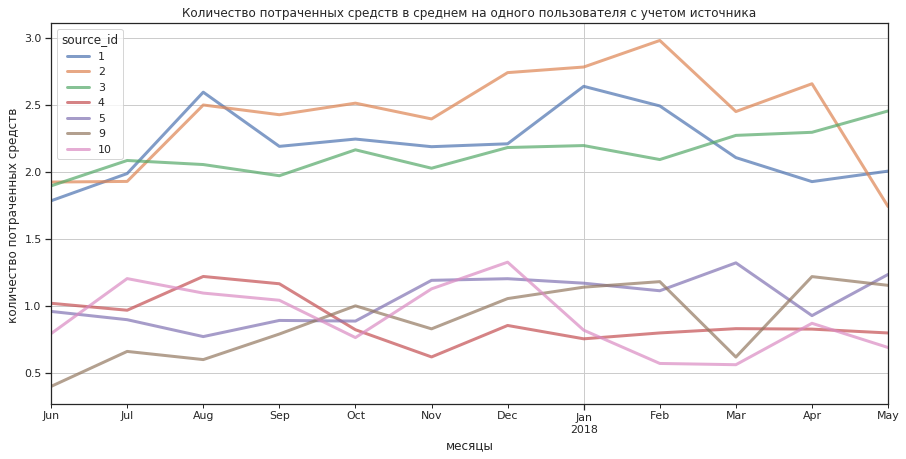

In [109]:
users_costs_per_user__mean_by_source_id.plot(linewidth = 3.0, figsize=(15, 7), alpha=0.7)
plt.grid(True)
plt.xlabel('месяцы')
plt.ylabel('количество потраченных средств ')
plt.title('Количество потраченных средств в среднем на одного пользователя с учетом источника');

#### Вывод:
Следуя нашим данным можно с уверенностью сказать что самым наиболее затратными источникомами являются источники номер 1,2,3 а самым наименее затратным источники по номер 4,5,9,10.Источники номер 6 и 7 судя по всему не пользовались спросом, так как пользователей с этих источников почти нет.Стоит задуматься о целесоообразности привлечения пользователей их этих источников. 

Попробуем выяснить сколько приносят пользователи денег (LTV), стоимость привлечения клиентов (cac) и окупаемость расходов (ROI)

Рассчитаем LTV для пользователей сделавших покупку разбив по источнику.

In [110]:
warnings.simplefilter("ignore")
current_users = users.query('payer == True')
current_users['acqusition_cost'] = current_users['payer_acqusition_cost']
cohorts = (current_users.groupby(['source_id'])
          .agg({'payer': 'count', 'acqusition_cost' : 'sum'})
          .rename(columns = {'payer':'cohort_size'}))
cohorts['cac'] = cohorts['acqusition_cost'] / cohorts['cohort_size']


ltv_by_source_id = orders.set_index('uid').join(users, how = 'left')[['acquisition_month', 'source_id', 'device',
                                                        'purchase_month', 'revenue']]


ltv_by_source_id['age_month'] = ((ltv_by_source_id['purchase_month'] - ltv_by_source_id['acquisition_month']) / np.timedelta64(1,'M')).round().astype('int')



ltv_by_source_id = ltv_by_source_id.groupby(['source_id'] + ['age_month']).agg({'revenue':'sum'})



ltv_by_source_id = pd.pivot_table(ltv_by_source_id,index = 'source_id', columns = 'age_month', values = 'revenue', aggfunc = 'sum')



ltv_by_source_id = ltv_by_source_id.cumsum(axis = 1)


ltv_by_source_id = cohorts[['cohort_size']].join(ltv_by_source_id)



ltv_by_source_id = ltv_by_source_id.div(ltv_by_source_id['cohort_size'], axis = 0).drop(columns = ['cohort_size'])
ltv_by_source_id = cohorts[['cohort_size','cac']].join(ltv_by_source_id[range(0,12)].fillna(''))
ltv_by_source_id = ltv_by_source_id.reset_index()
ltv_by_source_id

,source_id,cohort_size,cac,0,1,2,3,4,5,6,7,8,9,10,11
0,1,2899,7.171449,3.299596,4.094695,4.770931,5.838879,6.773291,7.825950,8.603101,9.175433,9.768658,10.253819,10.518686,10.724577
1,2,3506,12.176372,5.108574,6.328086,7.568742,8.956135,9.880262,11.082185,11.739179,12.271817,12.634079,12.885824,13.169119,13.383802
2,3,10473,13.493901,2.222396,2.743851,3.235424,3.653239,4.050193,4.387160,4.643024,4.836226,4.981325,5.099796,5.166700,5.204931
3,4,10296,5.930255,2.346389,2.891058,3.333632,3.787444,4.194955,4.539014,4.791864,5.039193,5.235698,5.377414,5.451470,5.506685
4,5,6931,7.467378,2.498543,3.199634,3.863367,4.509944,5.046103,6.103200,6.458942,7.055605,7.297853,7.457257,7.550896,7.592249
5,9,1088,3.858318,1.581893,2.028061,2.454963,2.920432,3.401397,3.904421,4.335147,4.669688,4.881581,5.043539,5.163925,5.293566
6,10,1329,4.064169,1.630956,1.911979,2.214635,2.466110,2.732942,2.900564,3.088209,3.161663,3.262709,3.304500,3.325583,3.348631


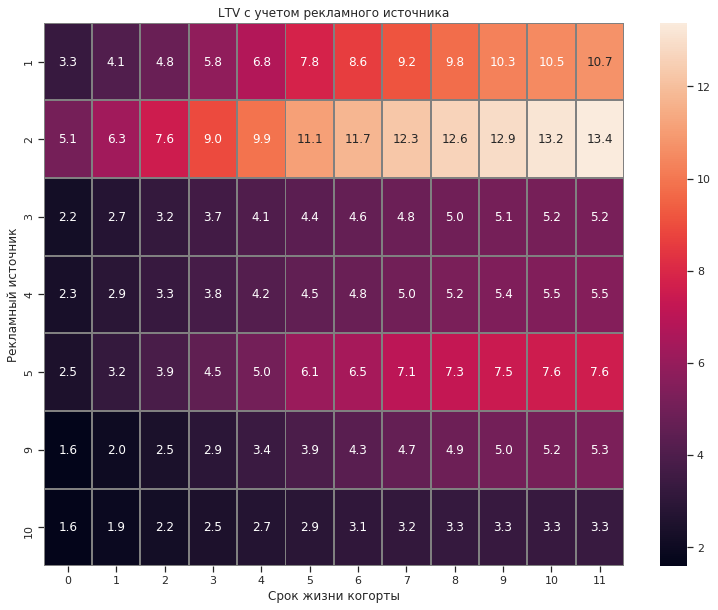

In [111]:
ltv_by_source_id_heatmap = ltv_by_source_id.drop(columns = {'cohort_size','cac'}).set_index('source_id')
sns.set(style='ticks')
plt.figure(figsize=(13, 10))
plt.title('LTV c учетом рекламного источника')
sns.heatmap(ltv_by_source_id_heatmap, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.ylabel('Рекламный источник')
plt.xlabel('Срок жизни когорты');

Рассчитаем сразу roi c разбиением когорт по источнику

In [112]:
roi_source_id = ltv_by_source_id
roi_source_id = roi_source_id.apply(pd.to_numeric)
roi_source_id = roi_source_id.div(roi_source_id['cac'], axis=0).drop(['cac','cohort_size','source_id'],axis=1)
roi_source_id = roi_source_id.set_index(ltv_by_source_id['source_id'])

In [113]:
roi_source_id

,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.460102,0.570972,0.665267,0.814184,0.944480,1.091265,1.199632,1.279439,1.362160,1.429811,1.466745,1.495455
2,0.419548,0.519702,0.621593,0.735534,0.811429,0.910138,0.964095,1.007839,1.037590,1.058265,1.081531,1.099162
3,0.164696,0.203340,0.239769,0.270733,0.300150,0.325122,0.344083,0.358401,0.369154,0.377933,0.382891,0.385725
4,0.395664,0.487510,0.562140,0.638665,0.707382,0.765399,0.808037,0.849743,0.882879,0.906776,0.919264,0.928575
5,0.334594,0.428482,0.517366,0.603953,0.675753,0.817315,0.864954,0.944857,0.977298,0.998645,1.011184,1.016722
9,0.409996,0.525633,0.636278,0.756918,0.881575,1.011949,1.123585,1.210291,1.265210,1.307186,1.338388,1.371988
10,0.401301,0.470448,0.544917,0.606793,0.672448,0.713692,0.759862,0.777936,0.802799,0.813081,0.818269,0.823940


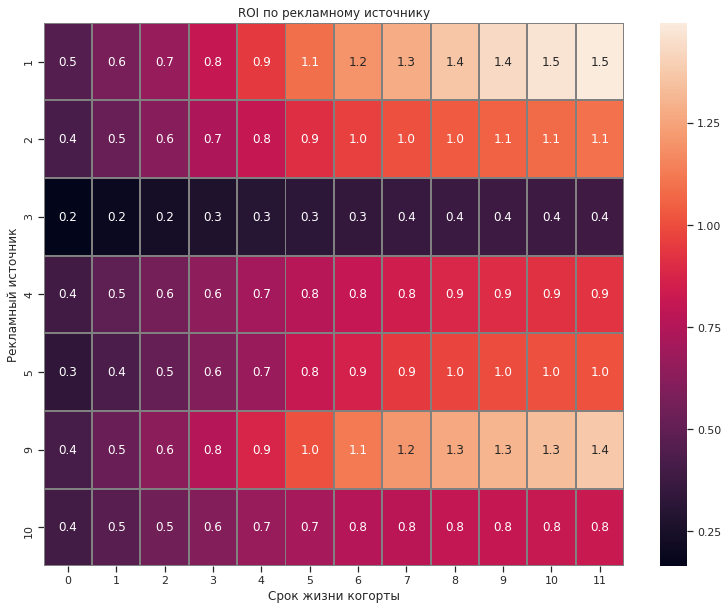

In [114]:
roi_source_id_heatmap = roi_source_id
sns.set(style='ticks')
plt.figure(figsize=(13, 10))
plt.title('ROI по рекламному источнику')
sns.heatmap(roi_source_id_heatmap, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.ylabel('Рекламный источник')
plt.xlabel('Срок жизни когорты');

#### Вывод:
Как мы видим максимальное LTV принадлежит источникам 1 и 2 соответственно.В свою очередь окупаемость расходов (ROI) достигается так же по этим двум источниками рекламы.Стоит еще отметить что источник рекламы под номером 9 хоть и не приносит больших денег, зато как первые два источника рекламы начинает окупаться в первые 5-6 месяцев.

Рассчитаем LTV для пользователей сделавших покупку разбив по устройству.

In [115]:
warnings.simplefilter("ignore")
current_users = users.query('payer == True')
current_users['acqusition_cost'] = current_users['payer_acqusition_cost']
cohorts = (current_users.groupby(['device'])
          .agg({'payer': 'count', 'acqusition_cost' : 'sum'})
          .rename(columns = {'payer':'cohort_size'}))
cohorts['cac'] = cohorts['acqusition_cost'] / cohorts['cohort_size']


ltv_by_device = orders.set_index('uid').join(users, how = 'left')[['acquisition_month', 'source_id', 'device',
                                                        'purchase_month', 'revenue']]


ltv_by_device['age_month'] = ((ltv_by_device['purchase_month'] - ltv_by_device['acquisition_month']) / np.timedelta64(1,'M')).round().astype('int')



ltv_by_device = ltv_by_device.groupby(['device'] + ['age_month']).agg({'revenue':'sum'})



ltv_by_device = pd.pivot_table(ltv_by_device,index = 'device', columns = 'age_month', values = 'revenue', aggfunc = 'sum')



ltv_by_device = ltv_by_device.cumsum(axis = 1)


ltv_by_device = cohorts[['cohort_size']].join(ltv_by_device)


ltv_by_device = ltv_by_device.div(ltv_by_device['cohort_size'], axis = 0).drop(columns = ['cohort_size'])
ltv_by_device = cohorts[['cohort_size','cac']].join(ltv_by_device[range(0,12)].fillna(''))
ltv_by_device = ltv_by_device.reset_index()
ltv_by_device

,device,cohort_size,cac,0,1,2,3,4,5,6,7,8,9,10,11
0,desktop,29210,9.010033,2.727377,3.401859,4.025711,4.671700,5.187720,5.858128,6.235204,6.595661,6.843751,7.029307,7.146558,7.234843
1,touch,7312,8.757168,2.249605,2.751009,3.196779,3.670124,4.192961,4.583073,4.857779,5.153818,5.335688,5.459516,5.542583,5.569651


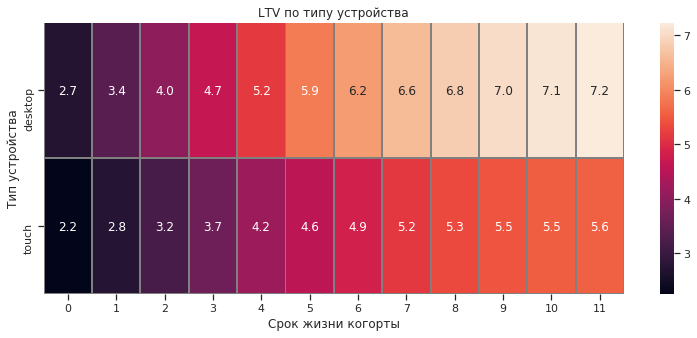

In [116]:
ltv_by_device_heatmap = ltv_by_device.drop(columns = {'cohort_size','cac'}).set_index('device')
sns.set(style='ticks')
plt.figure(figsize=(13, 5))
plt.title('LTV по типу устройства')
sns.heatmap(ltv_by_device_heatmap, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.ylabel('Тип устройства')
plt.xlabel('Срок жизни когорты');

Рассчитаем сразу roi c разбиением когорт по устройству.

In [117]:
roi_device = ltv_by_device.drop(columns = ('device'))
roi_device = roi_device.apply(pd.to_numeric)
roi_device = roi_device.div(roi_device['cac'], axis=0).drop(['cac','cohort_size'],axis=1)
roi_device = roi_device.set_index(ltv_by_device['device'])

In [118]:
roi_device

,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,
desktop,0.302704,0.377563,0.446803,0.518500,0.575772,0.650178,0.692029,0.732035,0.759570,0.780164,0.793178,0.802976
touch,0.256887,0.314144,0.365047,0.419099,0.478803,0.523351,0.554720,0.588526,0.609294,0.623434,0.632920,0.636011


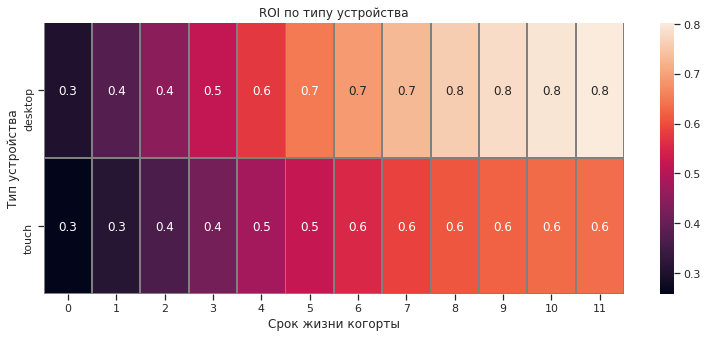

In [119]:
roi_device_heatmap = roi_device
sns.set(style='ticks')
plt.figure(figsize=(13, 5))
plt.title('ROI по типу устройства')
sns.heatmap(roi_device_heatmap, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.ylabel('Тип устройства')
plt.xlabel('Срок жизни когорты');

#### Вывод:
Если рассматривать LTV и ROI с точки зрения типа устройства,то можно сделать следующие выводы:
- 1) пользователи испльзующие тип устройства descktop показывают большее LTV.Но стоит отметить что тип устройства touch отстает не намного.Стоит задуматься об увеличении пользователей в этом направлении
- 2) по показателю ROI так же лидирует тип устройства descktop, и тип устройства touch не намного отстает.Но не один из типов устройства не окупается.

Рассчитаем LTV для пользователей сделавших покупку разбив по месяцу первой покупки

In [120]:
warnings.simplefilter("ignore")
current_users = users.query('payer == True')
current_users['acqusition_cost'] = current_users['payer_acqusition_cost']
cohorts = (current_users.groupby(['acquisition_month'])
          .agg({'payer': 'count', 'acqusition_cost' : 'sum'})
          .rename(columns = {'payer':'cohort_size'}))
cohorts['cac'] = cohorts['acqusition_cost'] / cohorts['cohort_size']


ltv_acquisition_month = orders.set_index('uid').join(users, how = 'left')[['acquisition_month', 'source_id', 'device',
                                                        'purchase_month', 'revenue']]


ltv_acquisition_month['age_month'] = ((ltv_acquisition_month['purchase_month'] - ltv_acquisition_month['acquisition_month']) / np.timedelta64(1,'M')).round().astype('int')



ltv_acquisition_month = ltv_acquisition_month.groupby(['acquisition_month'] + ['age_month']).agg({'revenue':'sum'})



ltv_acquisition_month = pd.pivot_table(ltv_acquisition_month,index = 'acquisition_month', columns = 'age_month', values = 'revenue', aggfunc = 'sum')



ltv_acquisition_month = ltv_acquisition_month.cumsum(axis = 1)


ltv_acquisition_month = cohorts[['cohort_size']].join(ltv_acquisition_month)



ltv_acquisition_month = ltv_acquisition_month.div(ltv_acquisition_month['cohort_size'], axis = 0).drop(columns = ['cohort_size'])
ltv_acquisition_month = cohorts[['cohort_size','cac']].join(ltv_acquisition_month[range(0,12)].fillna(''))
ltv_acquisition_month = ltv_acquisition_month.reset_index()
ltv_acquisition_month['acquisition_month'] = ltv_acquisition_month['acquisition_month'].dt.strftime('%Y.%m.') 



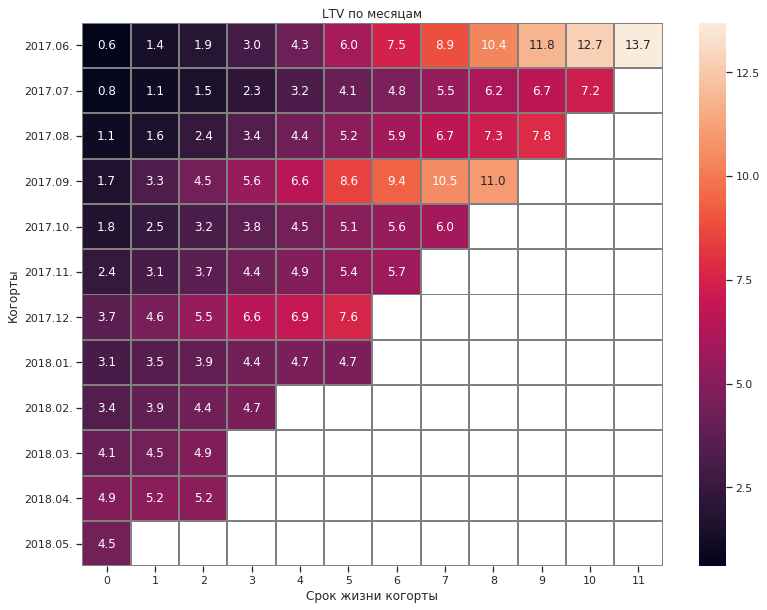

In [121]:
ltv_acquisition_month_to_numeric = ltv_acquisition_month.drop(columns = {'cohort_size','cac','acquisition_month'}).apply(pd.to_numeric)
ltv_acquisition_month_heatmap = ltv_acquisition_month_to_numeric.set_index(ltv_acquisition_month['acquisition_month'])
ltv_acquisition_month_heatmap.rename(columns = {'acquisition_month':'cohorts'}) 
sns.set(style='ticks')
plt.figure(figsize=(13, 10))
plt.title('LTV по месяцам')
sns.heatmap(ltv_acquisition_month_heatmap, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.ylabel('Когорты')
plt.xlabel('Срок жизни когорты');

Рассчитаем ROI с разбивкой по когортам.

In [122]:
roi_acquisition_month = ltv_acquisition_month.drop(columns = ['acquisition_month']).apply(pd.to_numeric)
roi_acquisition_month = roi_acquisition_month.div(roi_acquisition_month['cac'], axis=0).drop(['cac','cohort_size'],axis=1)

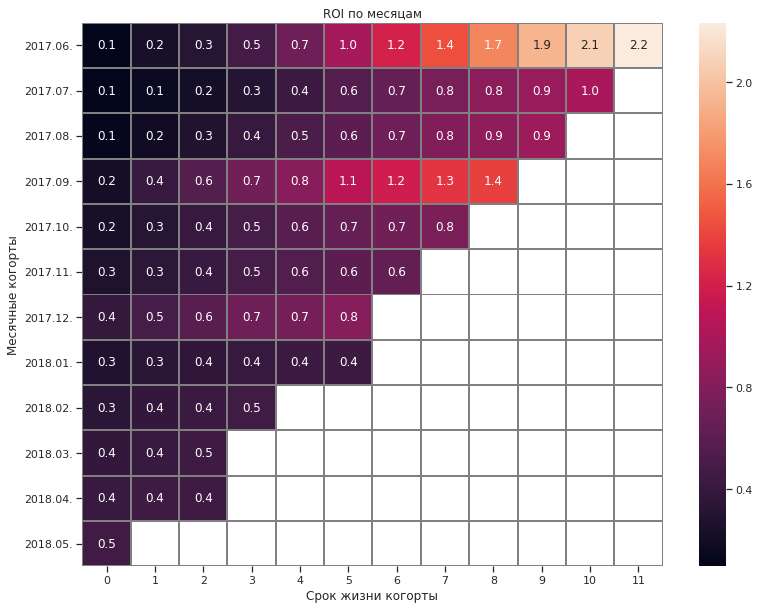

In [123]:
roi_acquisition_month_heatmap = roi_acquisition_month.set_index(ltv_acquisition_month['acquisition_month'])

sns.set(style='ticks')
plt.figure(figsize=(13, 10))
plt.title('ROI по месяцам')
sns.heatmap(roi_acquisition_month_heatmap, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.ylabel('Месячные когорты')
plt.xlabel('Срок жизни когорты');

#### Вывод:
Если рассматривать LTV и ROI c точки зрения месячных когорт, можно сказать выделить следующее:
- 1) LTV первой когорты самое большое по сравнению с остальными.Но если сравнить темпы роста когорты номер 4 с когортой номер 1, то номер 4 превосходит первую когорту.
- 2) Если говорить и ROI то единственными когортами которые окупились за период, так же являются когорты номер 1 и 4.Скорее всего люди которые начали использовать услуги нашего сервиса в эти месяцы получали какие-то скидки,бонусы и т.д.Нужно это проверить.

### 3) Общий вывод и принятие решения относительно поставленной задачи.

Проведя общий анализ с данными от Яндекс.Афиши с июня 2017 по конец мая 2018 года (в дальнейшем будем брать именно это период как за полный год) я сделал следующие выводы, и предположения:

 - 1) Чаще всего пользователи используют тип устройства `desktop`, нежели `touch`.Поэтому считаю целесообразным делать акцент на пользователей, которые используют тип устройства `desktop`.Данные основаны на расчете метрик `DAU`,`WAU`,`MAU`.

 - 2) Большая часть покупо и прирост пользователей совершается в холодное время года, когда пользователи чаще находятся дома.В связи с этим нужно скоцентрировать наши усилия по привлечению и удержанию пользователей именно в этот в период, а лучше в самом начале

 - 3) Так же необходимо проанализоровать версию сайта для устройств типа touch, не стоит отказываться от пользователей которые используют данный тип устройств.Оценить удобство пользования версии сайта для touch, интерфейс.Провести необходимые A/B тестирования 

 - 4) Приоритетными из числа рекламных источников, считаю источник номер 1,2 и 9.Своё заключение я сделал на основе метрики `LTV`, по количеству покупок.

 - 5) так же по моему мнению стоит отказаться от истоников номер 6 и 7.

 - 6) Что касается пользователей, хотелось бы отметить что необходимо делать упор на их привлечение в первой половине года (начиная с июля месяца).Еще по данным метрики удержания, и среднеко чека хотелось бы отметить необходимость ввдения скидок с учетом времени пользования нашим сервисом.Так как средний чек первых пользователей относительно начала года, намного выше нежели средний чек пользователей, которых мы преобрели в дальнейшем. 

